In [10]:
from qutip import basis, sigmax, sigmaz, sigmay, Options 
from qutip.solver.heom import DrudeLorentzBath
from qutip.solver.heom import HEOMSolver
from qutip.solver.heom import DrudeLorentzPadeBath
from qutip.solver.heom import BathExponent
import math
__all__ = ['parallel_map', 'serial_map', 'loky_pmap', 'mpi_pmap']

import multiprocessing
import os
import sys
import time
import threading
import concurrent.futures
import warnings
from qutip.ui.progressbar import progress_bars
from qutip.settings import available_cpu_count
from scipy.fft import fft, ifft 
from scipy.special import shichi
from mpmath import meijerg

import matplotlib.pyplot as plt
import qutip

import numpy as np 
import time 




# More flexibel solver for custom bath
from qutip.solver.heom import HSolverDL
from qutip.solver.heom import BosonicBath

import qutip.solver.brmesolve as brmesolve

In [11]:
"""Define Constants"""
#hbar, kb=1
we=1 # With hbar = 1 this is the upper energy
wg=0# ground state
ve=0.1 #  ground state frequencie from the exited atomic state in 0.1*we 
vg=0.1 # ground state frequencie from the ground atomic state 
λ1=0.5# dim less coupling constant depending on the shift of the energy minima shifts in space
g1=0.1 #couplig to the atom to the bath   
g2=0.1 #couplig to the vibronic modes to the bath 
tlist = np.linspace(0,40, 10000) # 40 times atomic frequencie 4 times vibronic
#### ground parameters
λ2=vg**2-ve**2/4*vg**2 # dim less coupling constant depending on the vibronic freq 
w0=we- wg + λ1**2 *vg**3 /ve**2
w00 = we - wg + (ve - vg )/2

gamma_1=0.1
gamma_2=0.1
beta=10 #temp Einheit von  hb*omega durch kb
A=-λ1/(1+4*λ2)
rs=2*(4*np.pi*1J+np.log(1+4*λ2)**0.25)
#nb=1/(np.exp((w) * beta)-1)
def nb(w):
    return 1/(np.exp((w) * beta)-1)
N=2# size of the vibronic hilbi space 
#tlist=np.linspace[0,1,10]
# operators
b  = qutip.tensor(qutip.qeye(2),qutip.destroy(N)) #ladder operator of the vibronic modes 
P12 = qutip.tensor(basis(2,0)*basis(2,1).dag(),qutip.qeye(N))
P21 = qutip.tensor(basis(2,1)*basis(2,0).dag(),qutip.qeye(N))
P11 = qutip.tensor(basis(2,0)*basis(2,0).dag(),qutip.qeye(N))
P22 = qutip.tensor(basis(2,1)*basis(2,1).dag(),qutip.qeye(N))
psi0 = qutip.tensor(basis(2,1),basis(N,0))   #|e,0>
rho0=qutip.tensor(basis(2,1)*basis(2,1).dag(),basis(N,0)*basis(N,0).dag()) #|e,0><e,0|


#System hamiltonian
H= vg*b.dag()*b +w0*P21*P12 + λ1*vg*(b+b.dag())*P21*P12+λ2*vg*(b+b.dag())**2  *P21*P12                     
H_diag=vg*P12*P21*b.dag()*b+ (vg*b.dag()*b+w00)*P21*P12
# H_int 
O1=P12+P21
O2=b+b.dag()

evals , ekets = H.eigenstates()
evals2 , ekets2 = H_diag.eigenstates()
print(H_diag)
#print(ekets,ekets2)
state1=qutip.tensor( basis(2,1),qutip.basis(N,0))
state2=qutip.tensor(basis(2,0),qutip.basis(N,1))
#print(state1.dag()*H_diag*state2)
def SS(H):
    return (-H*beta).expm()/((-H*beta).expm().tr())
print((SS(H)*P22).tr())
print((SS(H_diag)*P22).tr())



Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1.1]]
3.913288803119866e-05
4.5397868702434395e-05


In [12]:


# Displacement und Squeezing im Oszillatorraum
D_op = qutip.displace(N, A)
#S_op = qutip.squeeze(N, rs)
D_op= qutip.tensor(qutip.qeye(2), D_op )
#S_op = qutip.tensor(qutip.qeye(2),  S_op)
S_op = qutip.squeezing(b,b, rs)

U = P12*P21 +(D_op * S_op*P21*P12)
# Transformation auf sigma
P12r = U.dag() * P12 * U
P21r = U.dag() * P21 * U
#print(P12,P12r,D_op*S_op*P12)
U1 = P12*P21 +D_op *P21*P12
U2 = P12*P21 +S_op *P21*P12
#U=U1*U2
br=U.dag() *b * U
br2= b* P12*P21  +(b *np.cosh(rs)  - b.dag()*np.sinh(rs)+A*np.cosh(rs))*P21*P12
be = (np.cosh( rs) *b + np.sinh( rs)* b.dag() - 1/2*A* np.exp(rs) )*P21*P12

print(br,br2,be)
print(U.dag() *H *U)
c=b* P12*P21  +(b *np.cosh(rs)  - b*np.sinh(rs))*P22

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.          1.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.         -0.41006292  0.78609159]
 [ 0.          0.         -0.21390841  0.41006292]] Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.          1.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.         -0.68390196  1.42237929]
 [ 0.          0.         -1.01151513 -0.68390196]] Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.58512704 1.42237929]
 [0.         0.         1.01151513 0.58512704]]
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=Tru

/home/sander/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


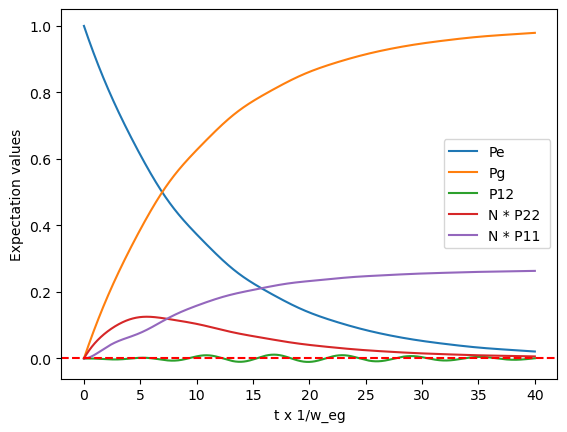

In [13]:
# decay 

########################################################################################################
gamma_1=0.1
gamma_2=0.1
c_op_list=[]

c_op_list.append(np.sqrt((nb(w0)+1)*gamma_1)*P12)
c_op_list.append(np.sqrt((nb(w0))*gamma_1)*P21)
c_op_list.append(np.sqrt((nb(vg)+1)*gamma_1)*b*P11)
c_op_list.append(np.sqrt((nb(vg))*gamma_1)*b.dag()*P11)
c_op_list.append(np.sqrt((nb(ve)+1)*gamma_1)*b*P22)
c_op_list.append(np.sqrt((nb(ve))*gamma_1)*b.dag()*P22)
Resul_Lindblad=qutip.mesolve(H, psi0, tlist, [c_op_list], [P22, P11,P12,b.dag()*b*P22,b.dag()*b*P11])

fig, ax = plt.subplots()
ax.plot(tlist, Resul_Lindblad.expect[0])
ax.plot(tlist, Resul_Lindblad.expect[1])
ax.plot(tlist, Resul_Lindblad.expect[2])
ax.plot(tlist, Resul_Lindblad.expect[3])
ax.plot(tlist, Resul_Lindblad.expect[4])
ax.set_xlabel('t x 1/w_eg')
ax.set_ylabel('Expectation values')
ax.legend(("Pe", "Pg","P12","N * P22 ","N * P11"))
ax.axhline(y=(SS(H)*P22).tr(), xmin=0, xmax=40, color='r', linestyle='--')
plt.show()